# Исследование продаж видеоигр

## 1. Загрузка и предобработка

In [1]:
conda install -c plotly plotly-orca

Note: you may need to restart the kernel to use updated packages.
Solving environment: ...working... done

# All requested packages already installed.




In [2]:
# Импортируем библиотеки, отключаем предупреждения

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from scipy import stats as st
from math import factorial
from plotly.subplots import make_subplots
import math
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Загрузка датасета

df = pd.read_csv('C:/Users/Acer/OneDrive/Рабочий стол/Яндекс Практикум/Сборный проект 1/games.csv')

In [4]:
def preprocess(df):
    """Принимает на вход датасет, возвращает первые 5 строк, общую информацию и число дубликатов"""
    display(df.head(5))
    display(df.info())
    display(df.duplicated().sum())
    
preprocess(df)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


None

0

Выводы:
1. В 6 из 11 столбцов есть пропуски; дубликатов нет.
2. Все названия столбцов приведем к нижнему регистру.
3. Столбец *Year_of_Release* необходимо привеcти к целочисленному типу, т.к. в нем записаны только значения лет, а месяцы и даты для анализа не требуются. 
4. Столбец *User_Score* приведем к типу float, т.к. значения оценок - это числа (целые или дробные).

In [5]:
# Приведем названия столбцов к нижнему регистру

df.columns = df.columns.str.lower()
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [6]:
#Выведем доли пропущенных значений по каждому из столбцов датафрейма

round((df.isna().mean()*100),2)

name                0.01
platform            0.00
year_of_release     1.61
genre               0.01
na_sales            0.00
eu_sales            0.00
jp_sales            0.00
other_sales         0.00
critic_score       51.32
user_score         40.09
rating             40.48
dtype: float64

Столбец "год выпуска": одна и та же игра может выходить на разных платформах в разное время, поэтому мы не можем применить к пропускам значения с других платформ. Возможные варианты - искать информацию и заполнять пропуски вручную или удалить их ввиду небольшого количества (1.61%). 

In [7]:
# Удаление пустых строк по столбцу с годом выпуска

df.dropna(subset=['year_of_release'],inplace=True)
print(df['year_of_release'].isna().sum())

0


In [8]:
# Замена типа данных столбца с годом выпуска

df['year_of_release'] = df['year_of_release'].astype('int')

Столбцы с оценками пользователей, критиков и рейтингом ESRB содержат большое кол-во пропусков. Заполнение их каким-либо значением нецелесообразно и может значительно исказить данные. Возможные причины появления пропусков:
- ошибки выгрузки данных с игровых платформ,
- по этим играм просто нет оценок. К примеру, в 2014 году было выпущено 2700 игр только для ПК, из них получили оценки около 700. Рынок видеоигр перенасыщен, поэтому сыграть в каждую физически невозможно. Из-за высокой конкуренции в поле зрения игроков и критиков попадают игры с огромными рекламными бюджетами; все остальные просто теряются на их фоне.

Удалять строки с пропусками по этим столбцам не будем, но при проверке гипотез сделаем срез только по заполненным значениям.

In [9]:
# Проверка уникальных значений столбца с оценками пользователей

df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [10]:
# Подсчет доли строк со значением tbd в столбце с оценками пользователей

tbd_part = round(len(df.query('user_score == "tbd"'))/len(df), 2)
tbd_part

0.14

Кроме чисел с плавающей точкой и пропусков в столбце встречаются значения "tbd", которые составляют 14% от всего датасета (англ. "to be determined" - "будет определено позже"). Вероятно по таким играм недостаточно оценок от пользователей на определенных платформах, чтобы рассчитать рейтинг. Заменим их маркером *-1*.

In [11]:
df['user_score'] = df['user_score'].replace('tbd', '-1')
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', '-1', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [12]:
# Замена типа данных столбца с оценками пользователей

df['user_score'] = df['user_score'].astype('float')

Пропуски по столбцу rating заменим значением "unknown". ESRB - североамериканский возрастной рейтинг, поэтому может быть проставлен не на всех играх (более подробно - в 3 разделе).

In [13]:
# Замена пропусков, проверка уникальных значений столбца

df['rating'] = df['rating'].fillna('unknown')
df['rating'].unique()

array(['E', 'unknown', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

In [14]:
# Выведем строки с пропусками по столбцу 'name'

df[df['name'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,unknown
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,unknown


Эти 2 строки также содержат пропуски по столбцу с жанром, оценками критиков и рейтингом ESRB. Данные не информативны, удалим эти строки.

In [15]:
df.dropna(subset=['name'],inplace=True)
print(df['name'].isna().sum())

0


In [16]:
# Проверка типов данных и кол-ва непропущенных значений

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       9839 non-null   float64
 10  rating           16444 non-null  object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.4+ MB


Все столбцы приведены к нужным типам, пропуски остались только в столбцах с оценками и рейтингом.

Добавим столбец с суммарными продажами по всем регионам:

In [17]:
df['total_sales'] = df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

In [18]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38


## 2. EDA

💡 *Рассчитаем количество игр по годам выпуска:*

In [19]:
year_grouped = df.pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'nunique').reset_index()
year_grouped.head()

,year_of_release,name
0,1980,9
1,1981,46
2,1982,36
3,1983,17
4,1984,14


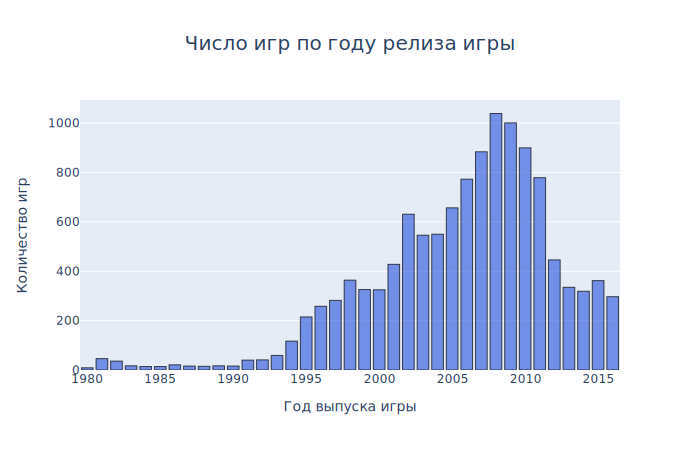

In [20]:
# Столбчатая диаграмма, отражающая динамику выпуска видеогр с 1980 по 2016гг.

fig = px.bar(year_grouped,
             x = 'year_of_release',
             y = 'name',
             title = 'Число игр по году релиза игры',
             hover_name='year_of_release',
             opacity = 0.7
            )

fig.update_layout(xaxis_title = 'Год выпуска игры',
                  yaxis_title = 'Количество игр',
                  title = {'font':dict(size=20), 'x':0.5})

fig.update_traces(marker=dict(color='RoyalBlue'),
                  hovertemplate = 'Год релиза: %{x} <br> Число игр: %{y}')
fig.data[0].marker.line.width = 1
fig.data[0].marker.line.color = 'black'

fig.show(renderer='svg');

В период с 1980 по 1993 гг. в год выходило не более 60 игр. Начиная с 1994 г. число ежегодно выпускаемых игр увеличивалось ~ на 100. Бум 90-х во многом обусловлен выпуском в 1993г. культовой игры, заложившей основы жанра шутер – Doom, а в 1994г. вышла Rise of the Triad – первая игра с мультиплеером. Стоит отметить, что развитие рынка видеоигр напрямую связано с развитием компьютерных технологий.

C 2000г. начался переход в полноценное 3D, а вскоре появилась реалистичная физика, анимация и эффекты. 

Предложение достигло своего пика в 2008г., когда игровыми изданиями было выпущено 1039 игр. Начиная с 2008г. на графике наблюдается резкое снижение числа релизов, и основной причиной для этого послужил мировой кризис. Он повлек за собой падение акций крупных игровых компаний, была закрыта часть студий и урезаны бюджеты, что также привело к ухудшению графики игр.

В настоящее время игровые издания делают упор на качество и внедрение новшеств в уже существующие популярные игры, а не на выпуск принципиально новых, которым будет сложно выдержать конкуренцию.

Т.к. это очень динамичный рынок, считаю целесообразным использовать для исследования данные последних нескольких лет (сколько точно определим после построения тепловой карты (ниже)).

💡 *Динамика продаж по платформам:*

In [21]:
pivot = df.pivot_table(
    index='platform', columns='year_of_release', values='total_sales', aggfunc='sum')
pivot.head()

year_of_release,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,,,,,,,,,,,,,
2600,11.38,35.68,28.88,5.84,0.27,0.45,0.67,1.94,0.74,0.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3DO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3DS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,63.20,51.36,56.57,43.76,27.78,15.14
DC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.02,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DS,NaN,NaN,NaN,NaN,NaN,0.02,NaN,NaN,NaN,NaN,...,146.94,145.31,119.54,85.02,26.18,11.01,1.54,NaN,NaN,NaN


Появление множества пропусков обусловлено отсутствием данных о продажах ранее года выпуска игры. В контексте нашей задачи можем заменить пропуски нулями.

In [22]:
pivot = pivot.fillna(0)
pivot.head()

year_of_release,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,,,,,,,,,,,,,
2600,11.38,35.68,28.88,5.84,0.27,0.45,0.67,1.94,0.74,0.63,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3DO,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3DS,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,63.20,51.36,56.57,43.76,27.78,15.14
DC,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.02,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
DS,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,...,146.94,145.31,119.54,85.02,26.18,11.01,1.54,0.00,0.00,0.00


💡 *Тепловая карта, отражающая число продаж по годам в разрезе платформ:*

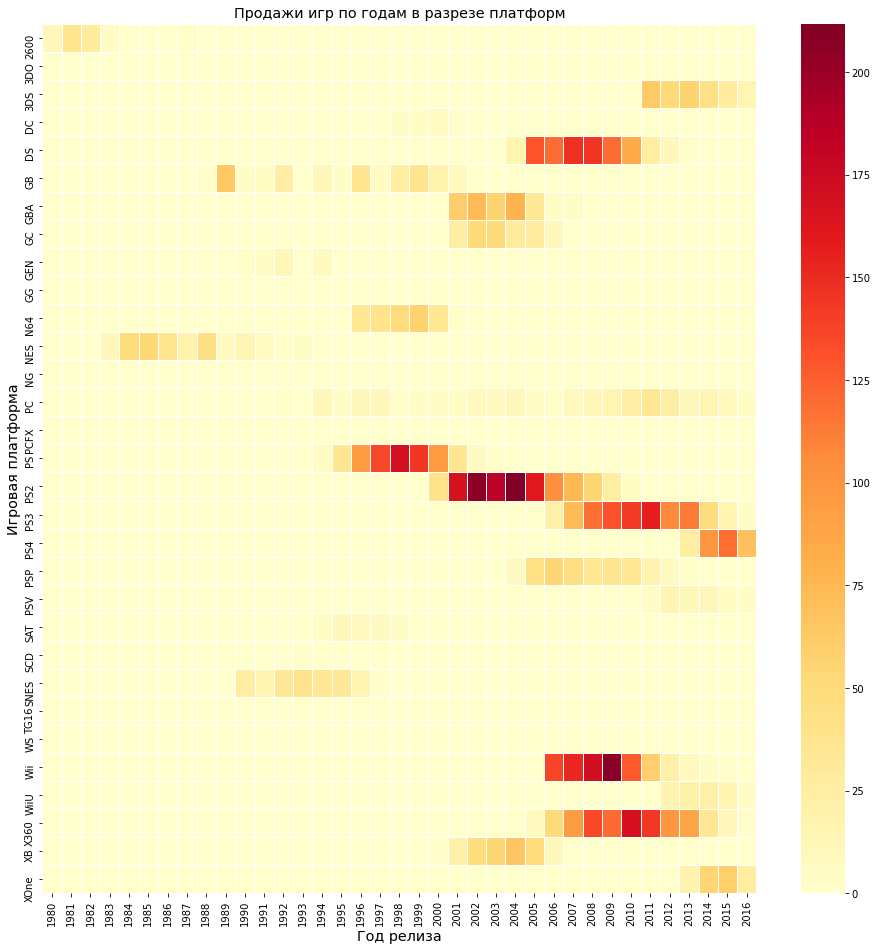

In [23]:
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(pivot, linewidth = 0.5, cmap = 'YlOrRd')
plt.xlabel('Год релиза', size='x-large')
plt.ylabel('Игровая платформа', size='x-large')
plt.title('Продажи игр по годам в разрезе платформ', size='x-large')
plt.show()

Исходя из графика, в 2013 году продажи по некоторым платформам начали падать (X360, Wii, PC), а по некоторым - расти (XOne, WiiU, PS4). Поэтому считаю использовать для анализа данные **с 2013 года.** 

Стоит отметить, что динамика продаж игр на платформах одного разработчика (Sony, Microsoft, Nintendo) имеет волнообразный характер. Когда выходит новая игровая консоль, продажи игр для нее резко увеличиваются, при этом число продаж для предыдущей версии приставки падает. Это можно увидеть по продажам PS2/PS3/PS4 и XB/X360/XOne. 

💡 *Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. Определим характерный срок, за который появляются новые и исчезают старые платформы:*

In [24]:
# Сводная таблица с суммарными продажами, сортировка по убыванию и выбор 4-x наиболее прибыльных.

df.pivot_table(
    index = 'platform',values = 'total_sales', aggfunc = 'sum').reset_index().sort_values(
    by='total_sales', ascending=False).head(4)

,platform,total_sales
16,PS2,1233.56
28,X360,961.24
17,PS3,931.34
26,Wii,891.18


In [25]:
def grouped(df, value):
    '''Функция для выделения платформы, группировки датафрейма по годам релиза и подсчета кол-ва игр для этой платформы'''
    return df.query('platform == @value').pivot_table(
    index = 'year_of_release', 
    values = 'total_sales', 
    aggfunc = 'sum').reset_index()

In [26]:
# Создание 5-и сгруппированных таблиц по платформам

ps2 = grouped(df, "PS2")
x360 = grouped(df, "X360")
wii = grouped(df, "Wii")
ps3 = grouped(df, "PS3")

In [27]:
def add_value_labels(df, ax):
    '''Функция добавляет значения маркеров на линейный график'''
    x = df['year_of_release']
    y = df['total_sales']
    for i, txt in enumerate(y):
        ax.annotate(round(txt, 2), (x[i], y[i]), size=10, ha='left')

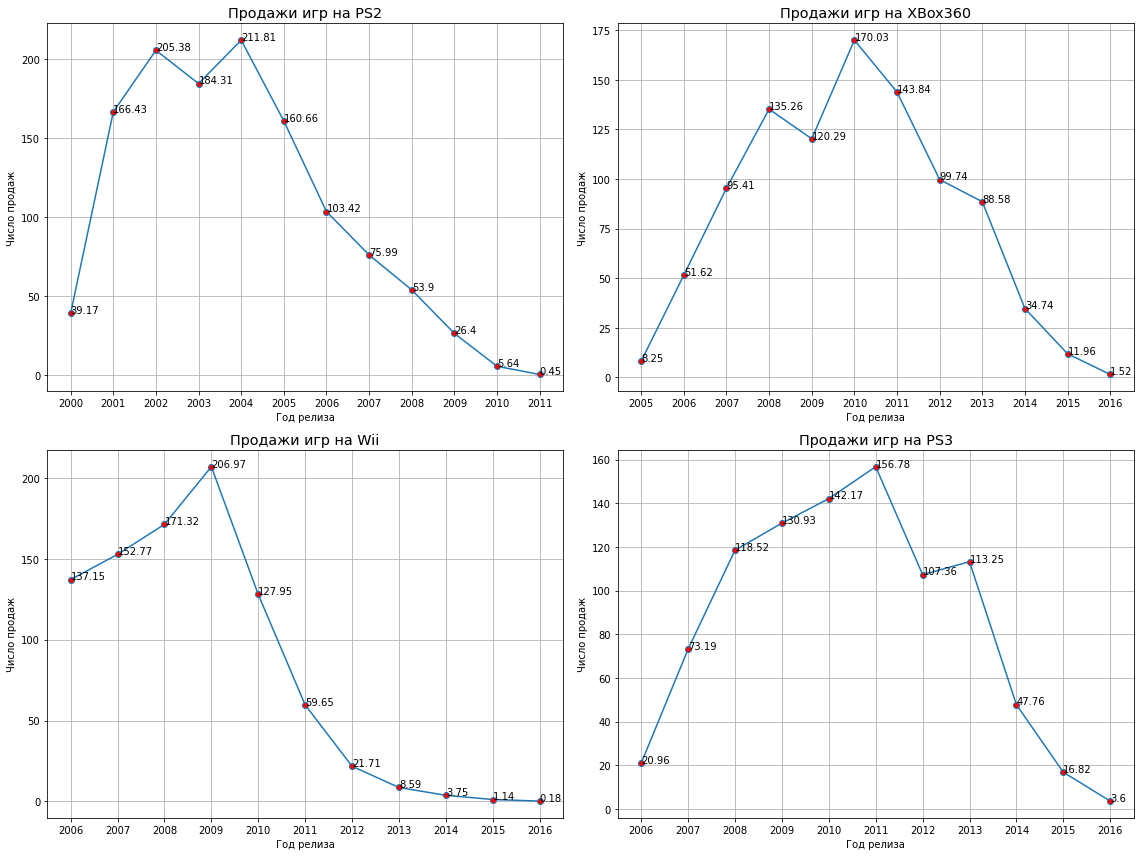

In [28]:
# Построение графиков с динамикой продаж по годам в разрезе самых прибыльных платформ

_, axs = plt.subplots(2, 2, figsize=(16, 12))  
axs = axs.ravel()

axs[0].plot(ps2['year_of_release'], ps2['total_sales'], marker='o', mfc='r')
axs[0].set_xlabel('Год релиза')
axs[0].set_ylabel('Число продаж')
axs[0].set_xticks(np.arange(np.min(ps2['year_of_release']),np.max(ps2['year_of_release']+1),1))
axs[0].set_title('Продажи игр на PS2', size='x-large')
add_value_labels(ps2, axs[0])
axs[0].grid()

axs[1].plot(x360['year_of_release'], x360['total_sales'], marker='o', mfc='r')
axs[1].set_xlabel('Год релиза')
axs[1].set_ylabel('Число продаж')
axs[1].set_xticks(np.arange(np.min(x360['year_of_release']),np.max(x360['year_of_release']+1),1))
axs[1].set_title('Продажи игр на XBox360', size='x-large')
add_value_labels(x360, axs[1])
axs[1].grid()

axs[2].plot(wii['year_of_release'], wii['total_sales'], marker='o', mfc='r')
axs[2].set_xlabel('Год релиза')
axs[2].set_ylabel('Число продаж')
axs[2].set_xticks(np.arange(np.min(wii['year_of_release']),np.max(wii['year_of_release']+1),1))
axs[2].set_title('Продажи игр на Wii', size='x-large')
add_value_labels(wii, axs[2])
axs[2].grid()

axs[3].plot(ps3['year_of_release'], ps3['total_sales'], marker='o', mfc='r')
axs[3].set_xlabel('Год релиза')
axs[3].set_ylabel('Число продаж')
axs[3].set_xticks(np.arange(np.min(ps3['year_of_release']),np.max(ps3['year_of_release']+1),1))
axs[3].set_title('Продажи игр на PS3', size='x-large')
add_value_labels(ps3, axs[3])
axs[3].grid()

plt.tight_layout()
plt.show();

**Срок жизни платформы составляет период от ее появления до пиковых продаж, т.е в среднем 4-5 лет.**
Продажи резко падают, когда разработчики анонсируют выпуск новых консолей. 

💡 *Какие платформы лидируют по продажам, растут или падают? Определим несколько потенциально прибыльных платформ.*

In [29]:
# Из сгруппированной по платформам и годам таблицы выделим интересующий нас период (2013 - 2016)

clean_df = pivot[[2013, 2014, 2015, 2016]]
clean_df.head()

year_of_release,2013,2014,2015,2016
platform,,,,
2600,0.00,0.00,0.00,0.00
3DO,0.00,0.00,0.00,0.00
3DS,56.57,43.76,27.78,15.14
DC,0.00,0.00,0.00,0.00
DS,1.54,0.00,0.00,0.00


Полностью нулевые строки нас не интересуют, т.к. игры на таких платформах выходят уже более 4 лет, но продажи отсутствуют. Такие платформы не являются потенциально прибыльными.

In [30]:
clean_df.drop(clean_df.index[clean_df.iloc[:, 1:].eq(0).all(axis=1)], inplace=True)
clean_df

year_of_release,2013,2014,2015,2016
platform,,,,
3DS,56.57,43.76,27.78,15.14
PC,12.38,13.28,8.52,5.25
PS3,113.25,47.76,16.82,3.60
PS4,25.99,100.00,118.90,69.25
PSP,3.14,0.24,0.12,0.00
PSV,10.59,11.90,6.25,4.25
Wii,8.59,3.75,1.14,0.18
WiiU,21.65,22.03,16.35,4.60
X360,88.58,34.74,11.96,1.52


Тепловая карта, отражающая число продаж по годам в разрезе платформ:

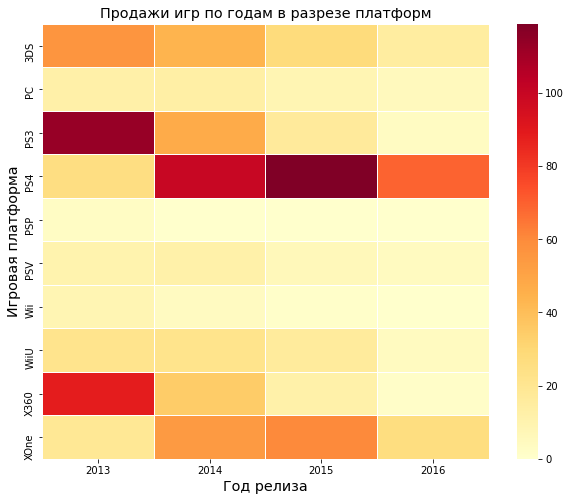

In [31]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(clean_df, linewidth = 0.5, cmap = 'YlOrRd')
plt.xlabel('Год релиза', size='x-large')
plt.ylabel('Игровая платформа', size='x-large')
plt.title('Продажи игр по годам в разрезе платформ', size='x-large')
plt.show()

В анализируемом периоде (с 2013 по 2016гг.) явными **лидерами продаж являются игры на платформах XOne и PS4.** Пик их популярности пришелся на 2015г., и несмотря на текущее снижение продаж, они по-прежнему лучше всего продаются, т.к. являются консолями последнего поколения.

С выходом новых версий гаджетов (игровые консоли, смартфоны и др.) пользователи стремятся приобретать именно их, т.к. они более производительные, соответственно, игровые издания в первую очередь выпускают игры для новейших платформ. Тем не менее, ввиду достаточно высокой стоимости новинок, предыдущее поколение консолей все-таки остается популярным (не все владельцы PS3 готовы моментально покупать PS4), поэтому и игры для предыдущего поколения платформ какое-то время все равно будут продаваться.

Также, **среди популярных можно выделить WiiU и 3DS**: выручка по ним не настолько высокая, как по PS и Xbox, тем не менее nintendo имеет свою целевую аудиторию (преимущественно в Японии).

В качестве потенциально прибыльных выделим **XOne, X360 (microsoft), PS3, PS4 (sony), WiiU и 3DS (nintendo).**

💡 *Построим боксплоты по глобальным продажам игр в разбивке по платформам.*

In [32]:
# Срез из интересующих нас платформ и периода исследования

data = df.query('platform in ("XOne", "X360", "PS3", "PS4", "WiiU", "3DS") and year_of_release>=2013')

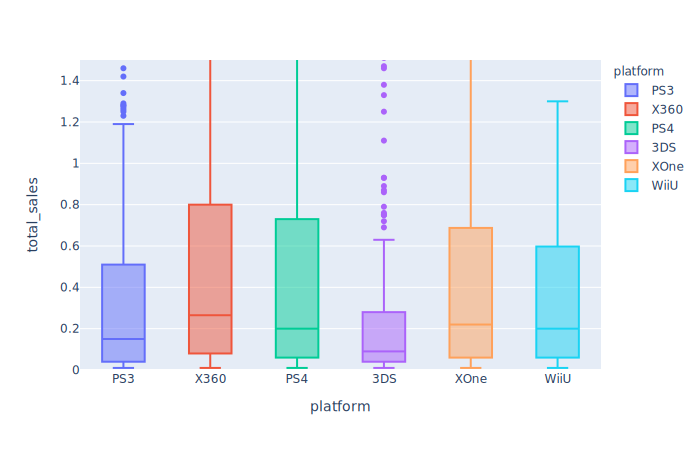

In [33]:
fig = px.box(data, x="platform", y="total_sales", color='platform')
fig.update_layout(yaxis=dict(range=[0, 1.5]))
fig.show(renderer='svg')

Исходя из графика, **не все игры одинаково успешны**: большинство  приносят мало выручки, либо вовсе не продаются, а бестселлерами становятся единицы (что также обусловлено высокой конкуренцией на рынке). Большинство игр не становятся хитами и продаются в среднем в количестве до 300 тыс. копий. Большую часть пространства занимают "выбросы", которые в нашем случае являются наиболее популярными играми. 

Медианное число продаж игр на платформе X360 больше, чем на всех остальных, однако на X360 не выходило игр с рекордными продажами в 21 млн. копий, как на PS3.

💡  *Оценим влияние на продажи внутри одной популярной платформы отзывов пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.*

Приведем оценки пользователей к 100-балльной шкале аналогично оценкам критиков:

In [34]:
data['user_score'] = data['user_score']*10
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,82.0,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,81.0,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,unknown,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,83.0,M,12.62


Для анализа влияния оценок на продажи возьмем платформу PS4.

In [35]:
ps4_data = data.query('platform == "PS4"')

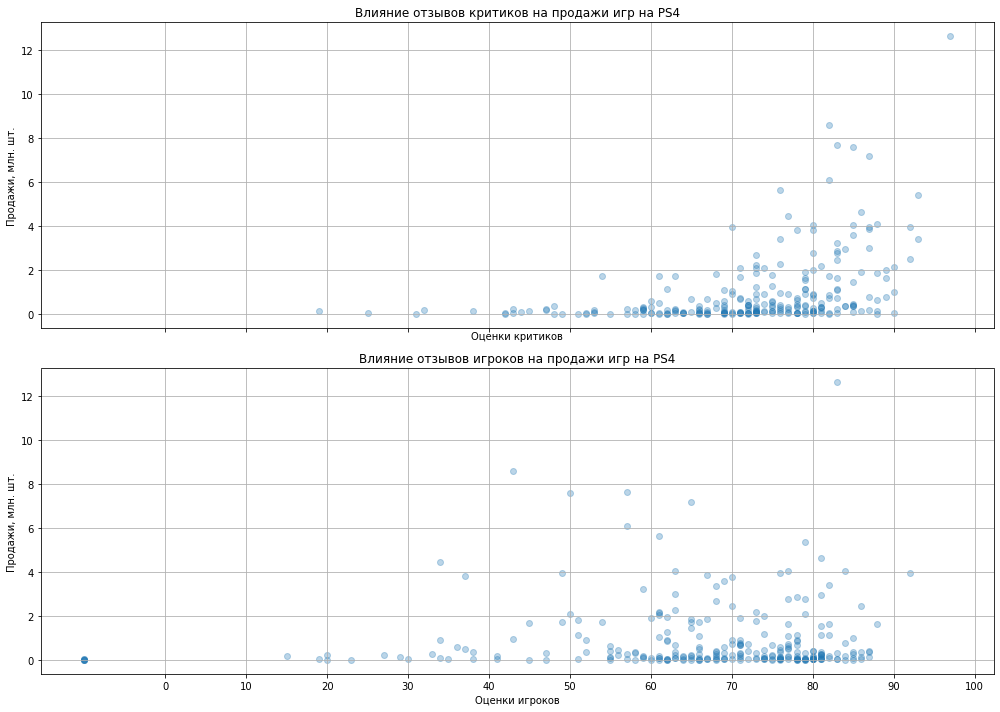

In [36]:
# Диаграммы рассеяния для оценок игроков и оценок критиков

_, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
ax = ax.ravel()

ax[0].scatter(ps4_data['critic_score'], ps4_data['total_sales'], alpha=0.3)
ax[0].set_xlabel('Оценки критиков')
ax[0].set_ylabel('Продажи, млн. шт.')
ax[0].set_title('Влияние отзывов критиков на продажи игр на PS4')
ax[0].set_xticks(np.arange(0, np.max(ps4_data['critic_score']+10),10))
ax[0].grid()

ax[1].scatter(ps4_data['user_score'], ps4_data['total_sales'], alpha=0.3)
ax[1].set_xlabel('Оценки игроков')
ax[1].set_ylabel('Продажи, млн. шт.')
ax[1].set_title('Влияние отзывов игроков на продажи игр на PS4')
ax[1].set_xticks(np.arange(0, np.max(ps4_data['user_score']+10),10))
ax[1].grid()

plt.tight_layout()
plt.show();

In [37]:
# Расчет корреляции между оценками и продажами игр на PS4

def corr(df):
    print('Корреляция между оценками игроков и продажами: {}'.format(
    round(df['user_score'].corr(df['total_sales']),2)))
    print('Корреляция между оценками критиков и продажами: {}'.format(
    round(df['critic_score'].corr(df['total_sales']),2)))

In [38]:
corr(ps4_data)

Корреляция между оценками игроков и продажами: 0.03
Корреляция между оценками критиков и продажами: 0.41


Исходя из графика, **продажи напрямую коррелируют с оценками критиков**, но скорее всего влияние обратно, т.е. чем более продаваема игра, тем больше шансов на высокие оценки критиков.

С оценками игроков другая ситуация - популярными становятся игры как с высокими, так и низкими оценками. Многие пользователи приобретают игры по предзаказу, когда не выставлены никакие оценки. Т.е. игра может стать хитом продаж, но, не оправдав ожидания игроков, получить низкий средний балл. Оценки не влияют существенно на выбор игры (например, в отличие от выбора фильма на кинопоиске), т.к. достаточно посмотреть стрим или геймплей, чтобы определиться с оценкой "нравится/не нравится".

Игроки и критики склонны оценивать игры по-разному - первые чаще, чем вторые, выставляют плохие оценки. Тем не менее, игрок равновероятно может поставить как 5.5, так и 8.5, в то время как критики придерживаются диапазона от 6 до 8. 

**В индустрии видеоигр нет конкретных критериев оценки** - оценка игроком гораздо больше зависит от личности и предпочтений, чем от качества самой игры, и зачастую выставляется интуитивно. И несмотря на то, что отзывам обычных людей доверяют больше, они гораздо более субъективны, чем оценки критиков (в том числе это показывает коэффициент корреляции). Вероятно, что такая закономерность не зависит от типа платформы и прослеживается также для остальных консолей.

In [39]:
x360_data = data.query('platform == "X360"')
xone_data = data.query('platform == "XOne"')
ps3_data = data.query('platform == "PS3"')
ds_data = data.query('platform == "3DS"')
wiiu_data = data.query('platform == "WiiU"')

In [40]:
corr(ps3_data)

Корреляция между оценками игроков и продажами: 0.11
Корреляция между оценками критиков и продажами: 0.33


In [41]:
corr(x360_data)

Корреляция между оценками игроков и продажами: 0.07
Корреляция между оценками критиков и продажами: 0.35


In [42]:
corr(xone_data)

Корреляция между оценками игроков и продажами: 0.09
Корреляция между оценками критиков и продажами: 0.42


In [43]:
corr(ds_data)

Корреляция между оценками игроков и продажами: 0.33
Корреляция между оценками критиков и продажами: 0.36


In [44]:
corr(wiiu_data)

Корреляция между оценками игроков и продажами: 0.35
Корреляция между оценками критиков и продажами: 0.38


**Корреляция между отзывами пользователей и критиков и продажами на PS4 схожа с корреляцией на всех платформах от microsoft и sony. А в Японии игроки и критики солидарны в своих оценках, т.к. коэффициент корреляции практически одинаковый.**

Построим общее распределение игр по жанрам:

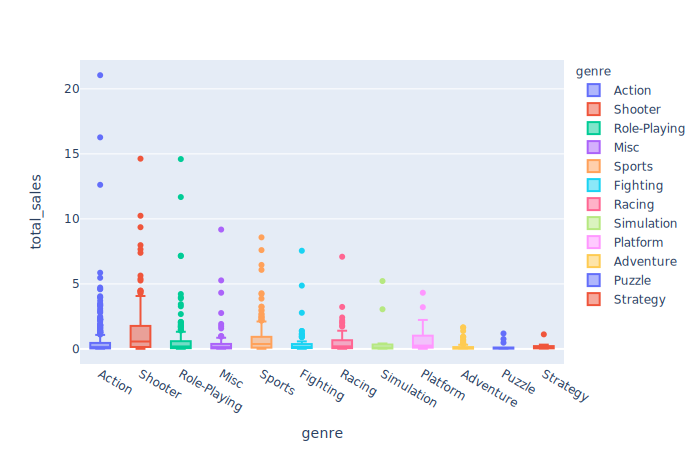

In [45]:
fig = px.box(data, x='genre', y='total_sales', color='genre')
fig.show(renderer='svg')

In [46]:
# Сводная таблица, отражающая число игр каждого жанра и суммарное число продаж

genres = data.pivot_table(
    index='genre', 
    values=['name', 'total_sales'], 
    aggfunc={'name':'count', 'total_sales':'sum'}).sort_values(by='total_sales', ascending=False)
genres.rename(columns={'name':'number_of_games'}, inplace=True)
genres.head()

,number_of_games,total_sales
genre,,
Action,569,300.71
Shooter,153,221.70
Sports,175,144.94
Role-Playing,189,129.76
Misc,116,50.95


In [47]:
# Добавим столбец со средним кол-вом продаж на 1 игру

genres['sales_per_game'] = round(genres['total_sales']/genres['number_of_games'], 2)
genres

,number_of_games,total_sales,sales_per_game
genre,,,
Action,569,300.71,0.53
Shooter,153,221.70,1.45
Sports,175,144.94,0.83
Role-Playing,189,129.76,0.69
Misc,116,50.95,0.44
Platform,62,39.15,0.63
Racing,66,38.82,0.59
Fighting,67,34.00,0.51
Adventure,113,18.76,0.17


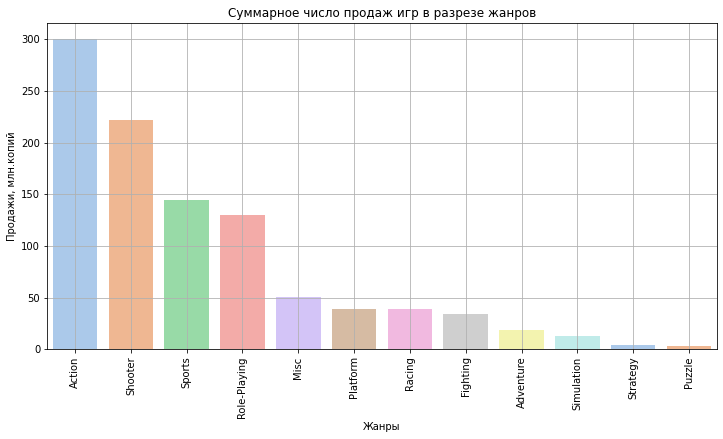

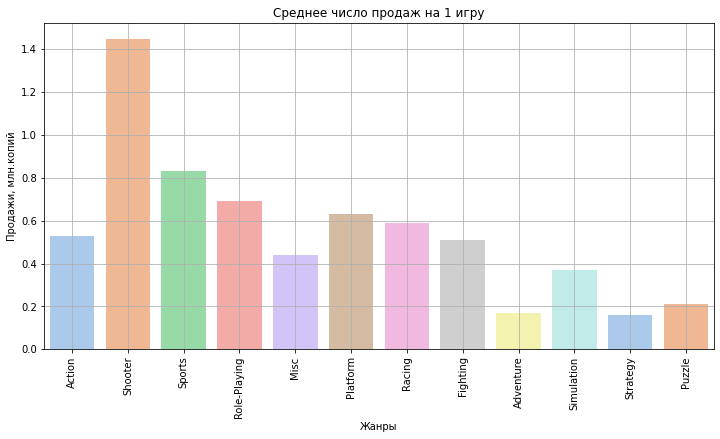

In [48]:
# Столбчатые диаграммы, отражающие суммарное число продаж и число продаж в среднем на 1 игру

plt.figure(figsize = (12, 6))
ax = sns.barplot(x=genres.index, y=genres['total_sales'],palette='pastel')
plt.xlabel('Жанры')
plt.ylabel('Продажи, млн.копий')
plt.title('Суммарное число продаж игр в разрезе жанров')
plt.xticks(rotation=90)
plt.grid()

plt.figure(figsize = (12, 6))
ax = sns.barplot(x=genres.index, y=genres['sales_per_game'],palette='pastel')
plt.xlabel('Жанры')
plt.ylabel('Продажи, млн.копий')
plt.title('Среднее число продаж на 1 игру')
plt.xticks(rotation=90)
plt.grid()
plt.show();

**Самыми популярными жанрами являюся экшен, стрелялки и спортивные игры, а самыми непопулярными - симулятор, стратегия и головоломки.**

Тем не менее, экшен показывает высокие результаты только за счет кол-ва игр; среднее число продаж на 1 игру составило лишь 0.53 млн. копий, в то время как жанры платформер, ролевые и гоночные игры более прибыльны, несмотря не небольшой выбор игр в данной тематике. А **самыми прибыльными являются игры в жанре "шутер"** - каждая игра в среднем продается в количестве 1.45 млн. копий.

## 3. Портрет пользователя каждого региона (NA, EU, JP)

💡  *Топ-5 популярных платформ, различия в долях продаж*

In [49]:
# Сводные таблицы - топ-5 популярных платформ по каждому региону

na_top = data.pivot_table(
    index='platform', 
    values='na_sales', 
    aggfunc='sum').sort_values(by='na_sales',ascending=False).head()

eu_top = data.pivot_table(
    index='platform', 
    values='eu_sales', 
    aggfunc='sum').sort_values(by='eu_sales',ascending=False).head()

jp_top = data.pivot_table(
    index='platform', 
    values='jp_sales', 
    aggfunc='sum').sort_values(by='jp_sales',ascending=False).head()

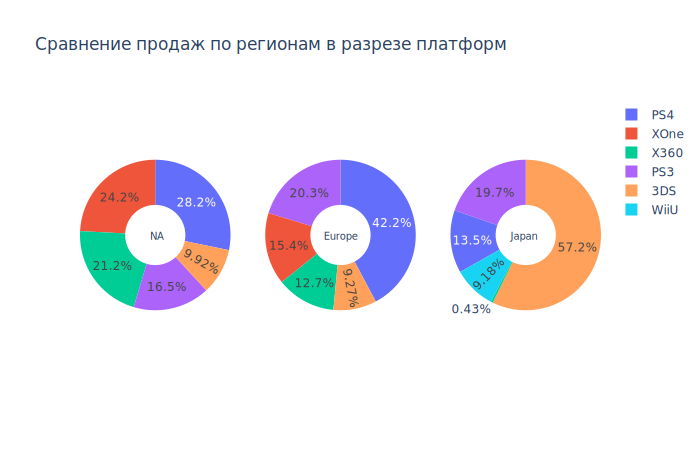

In [50]:
# Круговые диаграммы по продажам игр в регионах в разрезе платформ

fig = make_subplots(rows=1, cols=3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=na_top.index, values=na_top['na_sales'], name="North America"),
              1, 1)
fig.add_trace(go.Pie(labels=eu_top.index, values=eu_top['eu_sales'], name="Europe"),
              1, 2)
fig.add_trace(go.Pie(labels=jp_top.index, values=jp_top['jp_sales'], name="Japan"),
              1, 3)

fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Сравнение продаж по регионам в разрезе платформ",
    annotations=[dict(text='NA', x=0.13, y=0.5, font_size=10, showarrow=False),
                 dict(text='Europe', x=0.5, y=0.5, font_size=10, showarrow=False),
                 dict(text='Japan', x=0.88, y=0.5, font_size=10, showarrow=False)],
    autosize=False,
    width=800,
    height=400)
fig.show(renderer='svg')

Различия в долях продаж: **в Европе и Северной Америке лидирующей платформой является PS4**, при этом если американцы одинаково выбирают игры как от Microsoft, так от Sony (~ по 45%), то европейцы отдают предпочтение PS3 и PS4 (62.5%). При этом как в Америке, так и в Европе в топ-5 платформ не вошла ни одна консоль от Nintendo, т.к. в индустрии видеоигр **нормальна ситуация, когда та или иная игра не слишком популярна за пределами своего родного культурного пространства**. На данный момент Playstation является самой популярной консолью как в США, так и в большинстве европейских [стран](https://docs.google.com/spreadsheets/d/17v0a85RS6uOO8Im5UFH6EhIiHxUZ6Azja2qv7gpLgtE/edit#gid=0).

**На японском рынке игроки преимущественно выбирают игры от Nintendo (66.4%)**. В первую очередь это связано с отсылками в играх к японской культуре. С одной стороны, такой подход вырабатывает лояльность домашнего рынка, с другой - затрудняет выход многих проектов на мировой рынок.

💡 *Топ-5 популярных жанров.*

In [51]:
na_genres = data.pivot_table(
    index='genre', 
    values='na_sales', 
    aggfunc='sum').sort_values(by='na_sales',ascending=False).head()

eu_genres = data.pivot_table(
    index='genre', 
    values='eu_sales',
    aggfunc='sum').sort_values(by='eu_sales',ascending=False).head()

jp_genres = data.pivot_table(
    index='genre', 
    values='jp_sales', 
    aggfunc='sum').sort_values(by='jp_sales',ascending=False).head()

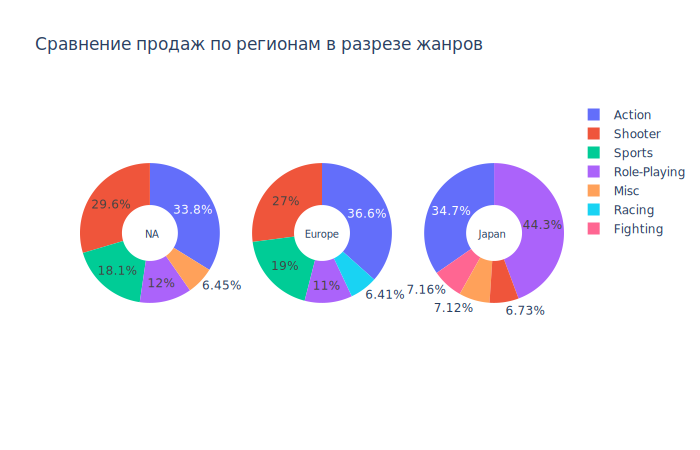

In [52]:
# Круговые диаграммы по продажам игр в регионах в разрезе жанров

fig = make_subplots(rows=1, cols=3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=na_genres.index, values=na_genres['na_sales'], name="North America"),
              1, 1)
fig.add_trace(go.Pie(labels=eu_genres.index, values=eu_genres['eu_sales'], name="Europe"),
              1, 2)
fig.add_trace(go.Pie(labels=jp_genres.index, values=jp_genres['jp_sales'], name="Japan"),
              1, 3)

fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Сравнение продаж по регионам в разрезе жанров",
    annotations=[dict(text='NA', x=0.13, y=0.5, font_size=10, showarrow=False),
                 dict(text='Europe', x=0.5, y=0.5, font_size=10, showarrow=False),
                 dict(text='Japan', x=0.88, y=0.5, font_size=10, showarrow=False)],
    autosize=False,
    width=800,
    height=400)
fig.show(renderer='svg')

**Структура распределения продаж игр по жанрам в США и Европе схожа**: на первом месте по продажам игры в жанре "экшен", на втором - "шутер" и на третьем - спортивные игры. Существенное различие лишь в жанрах аркадных игр и гонок. При этом если в Европе аркады следующие по популярности после гонок, то в США гонки в 2 раза менее популярны аркад.

Почти 80% японского игрового рынка поделили между собой RPG (44.3%) и экшен (34.7%). **Чтобы игра в Японии стала успешной, в ней должны присутствовать персонажи** (что обязательно есть в rpg). В Японии не распространены соревновательные игры, больше играют в игры, где есть элемент сотрудничества и мирного сосуществования — эта привычка может быть причиной непринятия спортивных игр и непопулярности шутеров.

💡 *Оценка влияния рейтинга ESRB на продажи в отдельном регионе.*

In [53]:
df['rating'].unique()

array(['E', 'unknown', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

In [54]:
data['rating'].unique()

array(['M', 'unknown', 'E', 'T', 'E10+'], dtype=object)

В срезе за актуальный период (2013-2016гг.) отсутствуют 4 обозначения возрастного рейтинга:

- K-A - "Для детей и взрослых": 3 игры, вышедших до 1997г. включительно. Устаревшее обозначение, в 1998 году был переименован в Е – для всех возрастов, а также чуть позже был добавлен рейтинг Е10+, как промежуточный между Е и Т.
- АО - "Только для взрослых": 1 игра (GTA: San Andreas), вышедшая в 2005г. Обычно этот рейтинг никто не хочет получить, так как велика вероятность, что игра вообще не окупится. Причины тому, что три основных производителя консолей (Nintendo, Sony и Microsoft) не разрешают выпускать игры с рейтингом AO на своих системах, как и большинство розничных магазинов.
- EC - "Для детей младшего возраста": выходили до 2011г. включительно
- RP - "Рейтинг ожидается": 1 игра (Supreme Ruler: Cold War) в 2011г.

In [55]:
# Сводные таблицы - продажи по каждому региону в зависимости от возрастного рейтинга

na_rating = data.pivot_table(
    index='rating', 
    values='na_sales', 
    aggfunc='sum').sort_values(by='na_sales',ascending=False)

eu_rating = data.pivot_table(
    index='rating', 
    values='eu_sales', 
    aggfunc='sum').sort_values(by='eu_sales',ascending=False)

jp_rating = data.pivot_table(
    index='rating', 
    values='jp_sales', 
    aggfunc='sum').sort_values(by='jp_sales',ascending=False)

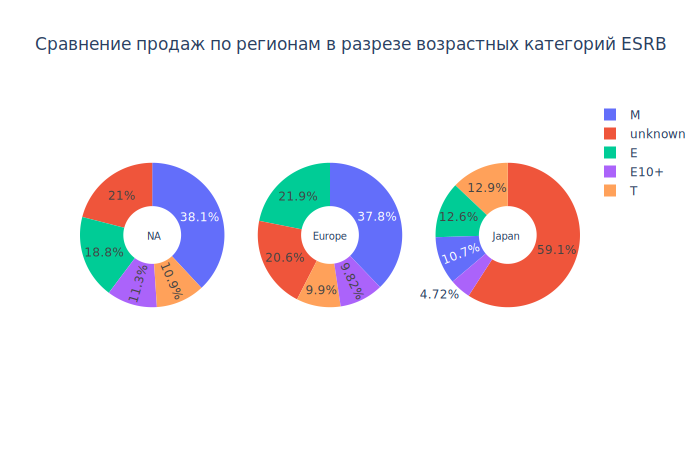

In [56]:
# Круговые диаграммы по продажам игр в регионах в разрезе возрастных категорий

fig = make_subplots(rows=1, cols=3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=na_rating.index, values=na_rating['na_sales'], name="North America"),
              1, 1)
fig.add_trace(go.Pie(labels=eu_rating.index, values=eu_rating['eu_sales'], name="Europe"),
              1, 2)
fig.add_trace(go.Pie(labels=jp_rating.index, values=jp_rating['jp_sales'], name="Japan"),
              1, 3)

fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Сравнение продаж по регионам в разрезе возрастных категорий ESRB",
    annotations=[dict(text='NA', x=0.13, y=0.5, font_size=10, showarrow=False),
                 dict(text='Europe', x=0.5, y=0.5, font_size=10, showarrow=False),
                 dict(text='Japan', x=0.88, y=0.5, font_size=10, showarrow=False)],
    autosize=False,
    width=800,
    height=400)
fig.show(renderer='svg')

Обозначения: 
- M - "От 17 лет"
- E - "Для всех"
- E10+ - "Для всех старше 10 лет"
- T - "Подросткам 13—19 лет"
- unknown - возрастная категория неизвестна

**В США и Европе наибольшее число продаж пришлось на игры с отметкой "от 17 лет"**, следом за ними почти одинаковые доли у игр с отметкой "для всех" и игр, возрастная категория которых неизвестна (без рейтинга ESRB). В многопользовательских сетевых играх, содержимое которых может модифицироваться (например, диалоги, карты, модели персонажей), используется замечание «Game Experience May Change During Online Play», которое предупреждает покупателей о том, что пользовательский контент в игре не проходил рецензирования ESRB. Проекты, которые распространяются исключительно в цифровом виде, получают рейтинг в системе IARC. Также, для Европы существует собственный возрастной рейтинг PEGI.

**В Японии лидерами продаж стали игры с без отметки ESRB.** Это объясняется тем, что в Японии есть собственная система оценки CERO (Организация компьютерных рейтингов развлечений), которая присваивает играм рейтинги букв, т.е. можно предположить, что японцы предпочитают игры собственного производства.

В целом, как уже отмечалось выше, лидерами игрового рынка США и Европы являются агрессивные игры, то есть те, что обозначены отметкой М. Данные по продажам в разрезе регионов отражают эти региональные предпочтения.

## 4. Проверка гипотез

💡 *Проверим гипотезы:*

1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
2. Средние пользовательские рейтинги жанров Action и Sports разные.

### 4.1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

In [57]:
# Разделим датасет на 2 по платформам  XOne и PC (с учетом актуального периода) и удалим пустые
# строки по столбцу user_score

xone = df.query('platform == "XOne" and year_of_release >= 2013').dropna(subset=['user_score'])
pc = df.query('platform == "PC" and year_of_release >= 2013').dropna(subset=['user_score'])

**Сначала оценим распределения на нормальность, чтобы выбрать корректный статистический тест:**

- H0 - данные распределены нормально

- H1 - данные распределены не нормально

In [58]:
# функция для проверки нормальности распределения

def shapiro(df,value):
    alpha = 0.05
    x,y = st.shapiro(df[value])
    print('p-значение:', y)
    if (y < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

In [59]:
shapiro(xone, 'user_score')

p-значение: 3.763992918482404e-15
Отвергаем нулевую гипотезу


In [60]:
shapiro(pc, 'user_score')

p-значение: 1.421458395434172e-09
Отвергаем нулевую гипотезу


**Нет оснований полагать, что данные по пользовательским оценкам распределены нормально**, поэтому для оценки равенства средних будем использовать тест Манна-Уитни (не требует наличия нормального распределения). Формулировка гипотезы содержит знак "равно", поэтому отнесем ее к нулевой гипотезе, а альтернативную сформулируем со знаком "!="

- H0 - средние пользовательские рейтинги платформ XOne и PC одинаковые

- H1 - средние пользовательские рейтинги платформ XOne и PC различаются

In [61]:
alpha = 0.05

results = st.mannwhitneyu(
    xone['user_score'], 
    pc['user_score'], alternative='two-sided')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.8323325581341586
Не получилось отвергнуть нулевую гипотезу


Т.е. **есть основания полагать, что средние пользовательские рейтинги платформ XOne и PC одинаковые.**

### 4.2. Средние пользовательские рейтинги жанров Action и Sports разные.

In [62]:
# Разделим датасет на 2 по жанрам Action и Sports (с учетом актуального периода) и удалим пустые
# строки по столбцу user_score

action = df.query('genre == "Action" and year_of_release >= 2013').dropna(subset=['user_score'])
sports = df.query('genre == "Sports" and year_of_release >= 2013').dropna(subset=['user_score'])

Гипотезы:

- H0 - средние пользовательские рейтинги жанров Action и Sports одинаковые

- H1 - средние пользовательские рейтинги жанров Action и Sports разные

In [63]:
alpha = 0.05

results = st.mannwhitneyu(
    action['user_score'], 
    sports['user_score'], alternative='two-sided')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.9135578701064787e-16
Отвергаем нулевую гипотезу


Т.е., есть основания полагать, что **игры в жанрах Action и Sports заработали разные средние оценки пользователей.**

## 5. Общий вывод

Мы исследовали данные о продажах игр, оценках пользователей и экспертов, жанрах и платформах **за период с 2013 по 2016гг.** 

Во-первых, хотелось бы отметить, что **индустрия видеоигр - очень динамичный рынок, на который оказывают влияние как развитие новых технологий, так и экономическая и социальная обстановка в мире**. В период кризиса 2008г. производство игр резко сократилось, но возросло их потребление, т.к. это один из самых доступных видов развлекательного контента. Консоли быстро морально устаревают с выходом более производительных, что отчетливо видно на тепловой карте по всем платформам. Поэтому для прогнозирования стоит использовать данные не более чем 3-летней давности.

Во-вторых, **на продажи игр существенно влияет рынок сбыта, особенно ярко эти различия проявляются между азиатским и западным рынками**. Платформы становятся наиболее успешными на домашнем рынке, а некоторые и вовсе не выходят за его пределы, как это было с некоторыми консолями nintendo. Так, игры на 3DS и WiiU наиболее популярны в Японии и не входят в топ-5 платформ на западе, поэтому маловероятно, что какая-либо новая игра на nintendo станет бестселлером в США или Европе. То же самое можно сказать о популярности игр на playstation и xbox в Японии. 

В-третьих, **на выбор игрового жанра влияют культурные особенности региона**. Так, на западе отдают предпочтение шутерам и экшену, а в Японии - RPG. В целом Япония - очень специфичный рынок и выбор японцев редко совпадает с выбором американцев/европейцев; это касается не только видеоигр, но и остального развлекательного контента. Несмотря на популярность жанра экшен, бОльшие продажи на 1 игру показывает жанр стрелялок. Именно этот показатель (а не суммарные продажи) стоит оценивать разработчикам при создании игры.

Успешность игры в США и Европе не определяется оценками пользователей, но в какой-то мере коррелирует с оценками критиков. Если у критиков есть относительно логичные критерии оценки (графика, звук, сюжет, геймплей), то отзывы игроков в основном зависят от предпочтений, настроения и ожиданий конкретного человека. Для принятия решения о покупке той или иной игры ни пользовательский рейтинг, ни оценки критиков не играют важной роли. Однако, в Японии игроки видимо более ответственно относятся к оценке игр, т.к. их отзывы идентичны оценкам критиков.